In [245]:
import numpy as np
import pandas as pd
import glob
from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras

In [2]:
# Dataset is divided in 4 files, this concatenates them all
df_list = []
for file_name in glob.glob("../Data/Raw/Archive/*.txt"):
    df_temp = pd.read_csv(file_name, sep="\t")
    df_list.append(df_temp)
df = pd.concat(df_list, axis=0, ignore_index=True)

In [3]:
df

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...
19365,7153718@N04,11598838386_349a0d4849_o.jpg,2282,None,NaN,596,460,1472,1473,-75,0,30
19366,7153718@N04,11598166203_c70bb34c80_o.jpg,2283,None,NaN,1179,755,331,331,5,0,108
19367,7153718@N04,11598166203_c70bb34c80_o.jpg,2282,None,NaN,1201,1179,293,293,5,0,99
19368,7153718@N04,11598145163_733cb99713_o.jpg,2282,None,NaN,1027,946,408,408,-85,0,49


In [4]:
df = df.dropna()

In [5]:
df["age"].value_counts()

(25, 32)     4953
(0, 2)       2488
(38, 43)     2293
(4, 6)       2140
(8, 12)      2119
(15, 20)     1642
(60, 100)     867
(48, 53)      825
35            293
13            168
22            149
34            105
23             96
45             88
(27, 32)       77
55             76
36             56
(38, 42)       46
None           40
57             24
3              18
29             11
(38, 48)        6
58              5
2               3
(8, 23)         1
42              1
46              1
Name: age, dtype: int64

Age map to use for regression, this dataset is meant to make the age a classification problem, but we are going to make it a regression one

In [6]:
df = df[df["age"] != "None"]

ages_map = {}
ages_keys = df["age"].value_counts().index
ages_values = []

for x in df["age"].value_counts().index:
    if x.startswith("("):
        x = x.split(", ")
        x[0] = x[0].replace("(","")
        x[1] = x[1].replace(")","")
        x[0] = int(x[0])
        x[1] = int(x[1])
        x = int((x[0]+x[1])/2)
        ages_values.append(x)
    else:
        ages_values.append(int(x))

In [7]:
for key, value in zip(ages_keys, ages_values):
    ages_map[key] = value

In [8]:
df["age"] = df["age"].map(ages_map)

In [9]:
df["gender"].value_counts()

f    9332
m    8120
u    1099
Name: gender, dtype: int64

In [10]:
# We will later make the model predict a non-binary category

df = df[df["gender"] != "u"]
df["gender"] = df["gender"].apply(lambda x: 1 if x == "m" else 0).astype(int)

In [227]:
# Creating the path to the image

df["face_id"] = df["face_id"].astype(str)
df["path"] = "../Data/Raw/Archive/Faces/"+df["user_id"]+"/coarse_tilt_aligned_face."+df["face_id"]+"."+df["original_image"]

In [228]:
X = df["path"]
y_age = df["age"]
y_gender = df["gender"]

In [274]:
X_train, X_test, y_train_age, y_test_age = train_test_split(X, y_age, test_size = 0.22, random_state = 22)
X_train, X_test, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size = 0.22, random_state = 22)

Image greyscaled, downscaled, size adjusted and transformed.

In [248]:
def image_preprocess(path):
    img = tf.io.read_file(np.array(path).ravel()[0])
    img = tf.image.decode_jpeg(img, channels = 1, ratio = 2)
    img = tf.image.resize(img, [64,64])
    img = img / 255 # This part normalizes the image, scaling it down; 255 is the max, while 0 is the min
    return img

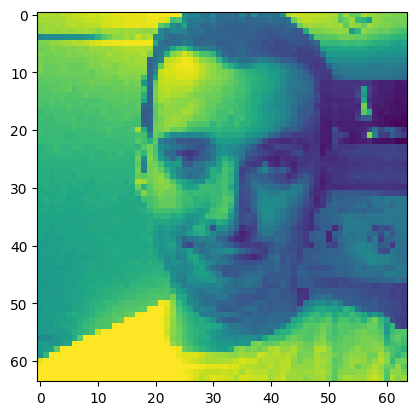

In [36]:
plt.imshow(image_preprocess(df["path"][22]))

In [16]:
# Preparing the data that will be fed to the model

X_train_images = np.array([image_preprocess(path) for path in X_train])
X_test_images = np.array([image_preprocess(path) for path in X_test])

In [21]:
model = Sequential()
# First layer needs as many nodes as inputs
model.add(Conv2D(64,(3,3), activation = "relu", input_shape = (64,64,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3), activation = "relu"))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3), activation = "relu"))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dense(1, activation = "relu"))
model.compile(optimizer = "adam",
              loss = "mse",
              metrics = ["mae", "mse", "mape"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)        

In [19]:
early_stop = EarlyStopping(patience=5)

checkpoint_path = '../Models/Age_NN3.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=False,
    verbose=1
)

In [22]:
history = model.fit(
    X_train_images, y_train_age,
    epochs=50,
    validation_data = (X_test_images, y_test_age),
    batch_size=20,
    verbose=2,
    callbacks=[early_stop,checkpoint]
)

Epoch 1/50

Epoch 1: saving model to ../Models\Age_NN3.hdf5
681/681 - 78s - loss: 355.7177 - mae: 14.3943 - mse: 355.7177 - mape: 257.8011 - val_loss: 303.0405 - val_mae: 13.4654 - val_mse: 303.0405 - val_mape: 252.5606 - 78s/epoch - 115ms/step
Epoch 2/50

Epoch 2: saving model to ../Models\Age_NN3.hdf5
681/681 - 81s - loss: 291.5183 - mae: 12.7084 - mse: 291.5183 - mape: 193.2929 - val_loss: 268.9490 - val_mae: 12.4735 - val_mse: 268.9490 - val_mape: 202.2239 - 81s/epoch - 119ms/step
Epoch 3/50

Epoch 3: saving model to ../Models\Age_NN3.hdf5
681/681 - 76s - loss: 257.4636 - mae: 11.7447 - mse: 257.4636 - mape: 154.9011 - val_loss: 241.5464 - val_mae: 11.1862 - val_mse: 241.5464 - val_mape: 156.6035 - 76s/epoch - 112ms/step
Epoch 4/50

Epoch 4: saving model to ../Models\Age_NN3.hdf5
681/681 - 79s - loss: 228.7507 - mae: 10.9406 - mse: 228.7507 - mape: 129.3263 - val_loss: 220.5478 - val_mae: 10.3107 - val_mse: 220.5478 - val_mape: 111.2884 - 79s/epoch - 115ms/step
Epoch 5/50

Epoch 5:

In [299]:
model_gender = Sequential()
# First layer needs as many nodes as inputs
model_gender.add(Conv2D(64,(3,3), activation = "relu", input_shape = (64,64,1)))
model_gender.add(MaxPool2D((2,2)))
model_gender.add(Conv2D(64,(3,3), activation = "relu"))
model_gender.add(MaxPool2D((2,2)))
model_gender.add(Conv2D(64,(3,3), activation = "relu"))
model_gender.add(MaxPool2D((2,2)))
model_gender.add(Flatten())
model_gender.add(Dense(64, activation = "relu"))
model_gender.add(Dense(2, activation = "sigmoid"))
opt = keras.optimizers.Adam(learning_rate=0.003)
model_gender.compile(optimizer = opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = "accuracy")
model_gender.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_59 (MaxPoolin  (None, 6, 6, 64)       

In [253]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [300]:
early_stop = EarlyStopping(patience=5)

checkpoint_path = '../Models/Gender_NN6.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=False,
    verbose=1
)

schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [301]:
history = model_gender.fit(
    X_train_images, y_train_gender,
    epochs=50,
    validation_data = (X_test_images, y_test_gender),
    batch_size=1000,
    verbose=2,
    callbacks=[early_stop, checkpoint, schedule]
)

Epoch 1/50

Epoch 1: saving model to ../Models\Gender_NN6.hdf5
14/14 - 104s - loss: 0.7050 - accuracy: 0.5674 - val_loss: 0.6521 - val_accuracy: 0.6073 - lr: 0.0030 - 104s/epoch - 7s/step
Epoch 2/50

Epoch 2: saving model to ../Models\Gender_NN6.hdf5
14/14 - 90s - loss: 0.6653 - accuracy: 0.6053 - val_loss: 0.6548 - val_accuracy: 0.6190 - lr: 0.0030 - 90s/epoch - 6s/step
Epoch 3/50

Epoch 3: saving model to ../Models\Gender_NN6.hdf5
14/14 - 86s - loss: 0.6325 - accuracy: 0.6358 - val_loss: 0.6205 - val_accuracy: 0.6398 - lr: 0.0030 - 86s/epoch - 6s/step
Epoch 4/50

Epoch 4: saving model to ../Models\Gender_NN6.hdf5
14/14 - 93s - loss: 0.5962 - accuracy: 0.6743 - val_loss: 0.6070 - val_accuracy: 0.6607 - lr: 0.0030 - 93s/epoch - 7s/step
Epoch 5/50

Epoch 5: saving model to ../Models\Gender_NN6.hdf5
14/14 - 91s - loss: 0.5644 - accuracy: 0.7010 - val_loss: 0.5613 - val_accuracy: 0.7091 - lr: 0.0030 - 91s/epoch - 6s/step
Epoch 6/50

Epoch 6: saving model to ../Models\Gender_NN6.hdf5
14/14

In [302]:
y_train_pred = model_gender.predict(X_train_images)
y_test_pred  = model_gender.predict(X_test_images)

120/120 [==============================] - 6s 51ms/step


In [287]:
y_train_pred2 = [int(round(y_train_pred[x][0],0)) for x in range(len(y_train_pred))]
y_test_pred2 = [int(round(y_test_pred[x][0],0)) for x in range(len(y_test_pred))]

In [303]:
y_train_pred3 = np.argmax(y_train_pred, axis=1).reshape(-1,1)
y_test_pred3 = np.argmax(y_test_pred, axis=1).reshape(-1,1)

In [304]:
print("Kappa score:",cohen_kappa_score(y_train_gender, y_train_pred3))
print(classification_report(y_train_gender, y_train_pred3, zero_division = True))

Kappa score: 0.7382755135116543
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      7317
           1       0.86      0.86      0.86      6295

    accuracy                           0.87     13612
   macro avg       0.87      0.87      0.87     13612
weighted avg       0.87      0.87      0.87     13612



In [305]:
print("Kappa score:",cohen_kappa_score(y_test_gender, y_test_pred3))
print(classification_report(y_test_gender, y_test_pred3, zero_division = True))

Kappa score: 0.6374297807267567
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      2015
           1       0.81      0.80      0.81      1825

    accuracy                           0.82      3840
   macro avg       0.82      0.82      0.82      3840
weighted avg       0.82      0.82      0.82      3840



In [306]:
model_gender.predict(np.array([image_preprocess("../Data/Test/Alfon.jpg")]))

1/1 [==============================] - 0s 69ms/step


array([[0.61628073, 0.13477637]], dtype=float32)

In [307]:
np.argmax(model_gender.predict(np.array([image_preprocess("../Data/Test/Ignacio.jpg")])), axis=1).reshape(-1,1)[0][0]

1/1 [==============================] - 0s 33ms/step


1

In [308]:
np.argmax(model_gender.predict(np.array([image_preprocess("../Data/Test/Ra.jpg")])), axis=1).reshape(-1,1)

1/1 [==============================] - 0s 28ms/step


array([[1]], dtype=int64)

In [309]:
model_gender.predict(np.array([image_preprocess("../Data/Test/Lydia2.jpg")]))[0]

1/1 [==============================] - 0s 28ms/step


array([0.27243468, 0.39943507], dtype=float32)